# Overview - maps

Load.

In [1]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import path
from matplotlib.gridspec import GridSpec

import convenience_funcs as cfs

import load_data
import munch
import sandwell
import utils

# Insert test comment

matplotlib.rc("font", size=7)
matplotlib.rc("axes", titlepad=1)

save_figs = True

pdd = "../data"
fsd = "../figures"
data_in = pdd

# Tidal frequencies (cpd)
M2 = 24.0 / 12.4206012
S2 = 24.0 / 12.0
K1 = 24.0 / 23.93447213

moorings = load_data.load_my_data()
ca, cw = load_data.load_my_data_alt()
ca = munch.munchify(ca)
cw = munch.munchify(cw)

moorings = [munch.munchify(m) for m in moorings]

cc, nw, ne, se, sw = moorings

ADCP = utils.loadmat(os.path.join(data_in, "ADCP.mat"))
ADCP = munch.munchify(ADCP)

topo = utils.loadmat(os.path.join(data_in, "topo_info.mat"))
topo = munch.munchify(topo)

VMP = utils.loadmat(os.path.expanduser("../data/jc054_vmp_cleaned.mat"))[
    "d"
]
VMP = munch.munchify(VMP)

alt_file = os.path.expanduser(
    "../data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3_1514910227973.nc"
)
alt = xr.open_dataset(alt_file)

## Map

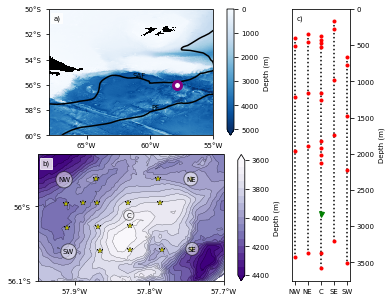

In [2]:
pf = np.genfromtxt(os.path.expanduser("~/data/orsi_fronts/pf.txt"), comments="%")
saf = np.genfromtxt(os.path.expanduser("~/data/orsi_fronts/saf.txt"), comments="%")

gs = GridSpec(2, 2, hspace=0.15, wspace=0.1, width_ratios=[5, 1])
fig = plt.figure(figsize=(6.5, 5))
proj = ccrs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# Regional map
lon_lat = [-68, -55, -60, -50]
ax0 = fig.add_subplot(gs[0, 0], projection=proj)

lons, lats, bathy = sandwell.read_grid(lon_lat)
bathy = -1 * np.ma.masked_where(bathy > 0, bathy)

ax0.set_extent(lon_lat, ccrs.PlateCarree())

# ax0.contour(lons, lats, bathy.data, [0.], colors='k')
ax0.add_feature(cfeature.LAND, color="k")

C = ax0.pcolormesh(
    lons, lats, bathy, vmin=0.0, vmax=5000.0, cmap="Blues", rasterized=True
)

ax0.plot(pf[:, 0], pf[:, 1], "k-")
ax0.annotate("PF", xy=pf[300, :], xytext=(1, 2), textcoords="offset points")
ax0.plot(saf[:, 0], saf[:, 1], "k-")
ax0.annotate("SAF", xy=saf[300, :], xytext=(1, 1), textcoords="offset points")

ax0.plot(
    cc.lon,
    cc.lat,
    "o",
    color="white",
    markersize=8,
    markeredgewidth=3,
    markeredgecolor="purple",
)

ax0.set_xticks([-65, -60, -55], crs=proj)
ax0.set_yticks([-60, -58, -56, -54, -52, -50], crs=proj)
ax0.xaxis.set_major_formatter(lon_formatter)
ax0.yaxis.set_major_formatter(lat_formatter)

# Local map
ax1 = fig.add_subplot(gs[1, 0], projection=proj)
ax1.set_extent([-57.95, -57.7, -56.1, -55.93], ccrs.PlateCarree())
ax1.set_xticks([-57.9, -57.8, -57.7], crs=proj)
ax1.set_yticks([-56.1, -56], crs=proj)
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# for m in mooringsc:
#     ax1.plot(m['lon'], m['lat'], 'ko', markersize=6)


bbox_dict = dict(facecolor="w", edgecolor=None, boxstyle="circle", alpha=0.5)
ax1.annotate(
    "C",
    xy=(cc.lon, cc.lat),
    bbox=bbox_dict,
    horizontalalignment="center",
    verticalalignment="center",
)
ax1.annotate(
    "NW",
    xy=(nw.lon, nw.lat),
    bbox=bbox_dict,
    horizontalalignment="center",
    verticalalignment="center",
)
ax1.annotate(
    "NE",
    xy=(ne.lon, ne.lat),
    bbox=bbox_dict,
    horizontalalignment="center",
    verticalalignment="center",
)
ax1.annotate(
    "SE",
    xy=(se.lon, se.lat),
    bbox=bbox_dict,
    horizontalalignment="center",
    verticalalignment="center",
)
ax1.annotate(
    "SW",
    xy=(sw.lon, sw.lat),
    bbox=bbox_dict,
    horizontalalignment="center",
    verticalalignment="center",
)

CS = ax1.contourf(
    topo.lons,
    topo.lats,
    topo.depths.T,
    np.arange(3600.0, 4450.0, 50.0),
    cmap="Purples",
    extend="both",
)
ax1.contour(
    topo.lons,
    topo.lats,
    topo.depths.T,
    np.arange(3600.0, 4450.0, 50.0),
    colors="k",
    linewidths=0.2,
)
# plt.clabel(CS, inline=1, fontsize=8, fmt='%1.0f', manual=False)

# Add VMP stations
box = np.array([[-58.0, -58.0, -57.7, -57.7], [-56.15, -55.9, -55.9, -56.15]]).T
p = path.Path(box)
in_box = p.contains_points(np.vstack((VMP.startlon, VMP.startlat)).T)
idxs = np.argwhere(in_box).squeeze()

for i in idxs:
    ax1.plot(
        VMP.startlon[i],
        VMP.startlat[i],
        "y*",
        markersize=6,
        markeredgewidth=0.3,
        markeredgecolor="k",
    )

# AXIS 2
ax2 = fig.add_subplot(gs[:, 1])
for i, m in enumerate([nw, ne, cc, se, sw]):
    d_min = np.min(-m.z, axis=0)
    ax2.plot(i * np.ones_like(d_min), d_min, "k:")
    ax2.plot(i * np.ones_like(d_min), d_min, "ro", markersize=3)

ax2.plot(2, ADCP.z.min(), color="g", marker="v", markersize=5)

ax2.invert_yaxis()
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Depth (m)")
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xticklabels(["NW", "NE", "C", "SE", "SW"])

# Massive fudge of position!!!
bbox0 = ax0.get_position()
# ax0.set_position((bbox0.x0, bbox0.y0 + 0.05, bbox0.width, bbox0.height))
cax0 = fig.add_axes((bbox0.x1 + 0.03, bbox0.y0, 0.015, bbox0.height))
cb0 = plt.colorbar(C, cax0, orientation="vertical", extend="max")
cb0.ax.invert_yaxis()
cb0.set_label("Depth (m)")

bbox1 = ax1.get_position()
# ax1.set_position((bbox1.x0 + 0.01, bbox1.y0 + 0.05, bbox1.width, bbox1.height))
cax1 = fig.add_axes((bbox1.x1 + 0.03, bbox1.y0, 0.015, bbox1.height))
cb1 = plt.colorbar(CS, cax1, orientation="vertical")
cb1.set_label("Depth (m)")
cb1.set_ticks([3600, 3800, 4000, 4200, 4400])
cb1.ax.invert_yaxis()

cfs.axes_labels(
    fig,
    [ax0, ax1, ax2],
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.01,
    dy=-0.03,
)

# fig.tight_layout()
if save_figs:
    fig.savefig(
        os.path.join(fsd, "regional_local_map.pdf"),
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.0,
    )
    fig.savefig(
        os.path.join(fsd, "regional_local_map.png"),
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.0,
    )

<a id="interpolation_diagram"></a>

## Interpolation diagram

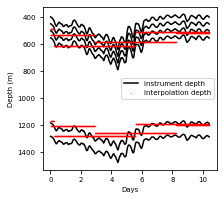

In [3]:
i0, i1 = 1000, 2000
t0 = cc.t[i0, 0]
t1 = cc.t[i1, 0]
user = (cc.t[:, 0] > t0) & (cc.t[:, 0] < t1)
usew = (cw.t[..., :2] > t0) & (cw.t[..., :2] < t1)

fig, ax = plt.subplots(1, 1, figsize=(3.125, 3))
lines = ax.plot(cc.t[user, 0] - t0, -cc.z[user, :6], "k", label="instrument height")

lines0 = ax.plot(
    cw.t[..., :2][usew] - t0,
    -cw.zi[..., :2][usew],
    "r.",
    markersize=0.5,
    label="interpolation depth",
)

ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Days")
ax.legend((lines[0], lines0[0]), ("instrument depth", "interpolation depth"))
# fig.tight_layout()

if save_figs:
    fig.savefig(
        os.path.join(fsd, "interpolation_diagram.pdf"),
        bbox_inches="tight",
        dpi=300,
        pad_inches=0.0,
    )
    fig.savefig(
        os.path.join(fsd, "interpolation_diagram.png"),
        bbox_inches="tight",
        dpi=300,
        pad_inches=0.0,
    )

## Altimetry map plot

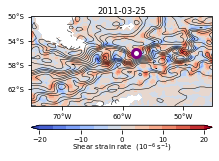

In [4]:
i = 114
st = 1
cmap = "coolwarm"
########
mlon = cc.lon
mlat = cc.lat
lon = alt.longitude.data - 360.0
lat = alt.latitude.data
nt, nx, ny = alt.ugosa.shape
ug = alt.ugos.data
vg = alt.vgos.data
adt = alt.adt.data
_, dudy = utils.spherical_polar_gradient_ts(ug, lon, lat)
dvdx, _ = utils.spherical_polar_gradient_ts(vg, lon, lat)
sstrain = dudy + dvdx
# nstrain = dudx - dvdy

ts = pd.to_datetime(alt.time.to_pandas())
d = ts.dt.strftime("%Y-%m-%d")

land = np.isnan(vg).astype(float)

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig = plt.figure(figsize=(3.25, 4))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

ax.set_xlim(alt.longitude_min - 360.0, alt.longitude_max - 360.0)
ax.set_ylim(alt.latitude_min, alt.latitude_max)

ax.set_title(d[i])

c = 1e6
C = ax.contourf(
    lon[::st],
    lat[::st],
    c * sstrain[i, ::st, ::st],
    c * np.linspace(-2e-5, 2e-5, 13),
    cmap=cmap,
    extend="both",
)
ax.contour(
    lon[::st],
    lat[::st],
    adt[i, ::st, ::st],
    np.arange(-1.4, 1.1, 0.1),
    colors="k",
    linewidths=0.5,
)


ax.plot(
    mlon,
    mlat,
    "o",
    color="white",
    markersize=8,
    markeredgewidth=3,
    markeredgecolor="purple",
)

ax.set_xticks([-70, -60, -50], crs=proj)
ax.set_yticks([-62, -58, -54, -50], crs=proj)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Massive fudge of position!!!
bbox = ax.get_position()
# ax0.set_position((bbox0.x0, bbox0.y0 + 0.05, bbox0.widt, bbox0.height))
cax = fig.add_axes((bbox.x0, bbox.y0 - 0.08, bbox.width, 0.015))
cb = plt.colorbar(C, cax, orientation="horizontal")
cb.set_ticks([-20, -10, 0.0, 10, 20])
cb.set_label("Shear strain rate  (10$^{-6}$ s$^{-1}$)", labelpad=-1)

# ax.add_feature(cfeature.LAND, color='k', alpha=0.3)
if save_figs:
    sname = "sstrain_snap.pdf"
    fig.savefig(os.path.join(fsd, sname), dpi=300, bbox_inches="tight", pad_inches=0)
    sname = "sstrain_snap.png"
    fig.savefig(os.path.join(fsd, sname), dpi=300, bbox_inches="tight", pad_inches=0)

## Output mooring lon lat in proper way...

In [5]:
for m in moorings:
    lon, lat = m["lon"], m["lat"]

    lonf = np.fix(lon)
    latf = np.fix(lat)

    lonsign = np.sign(lon)
    latsign = np.sign(lat)

    if lonsign == -1:
        EW = "W"
    elif lonsign == 1:
        EW = "E"

    if latsign == -1:
        NS = "S"
    elif latsign == 1:
        NS = "N"

    lonr = np.abs(lon - lonf)
    latr = np.abs(lat - latf)

    print(m["id"])
    print("lon")
    print("{:1.0f}$^\circ$ {:1.2f}$^\prime$ {}".format(np.abs(lonf), lonr * 60, EW))
    print("lat")
    print("{:1.0f}$^\circ$ {:1.2f}$^\prime$ {}".format(np.abs(latf), latr * 60, NS))

cc
lon
57$^\circ$ 49.66$^\prime$ W
lat
56$^\circ$ 0.71$^\prime$ S
nw
lon
57$^\circ$ 54.88$^\prime$ W
lat
55$^\circ$ 57.84$^\prime$ S
ne
lon
57$^\circ$ 44.66$^\prime$ W
lat
55$^\circ$ 57.78$^\prime$ S
se
lon
57$^\circ$ 44.54$^\prime$ W
lat
56$^\circ$ 3.43$^\prime$ S
sw
lon
57$^\circ$ 54.52$^\prime$ W
lat
56$^\circ$ 3.64$^\prime$ S


## Amount of mooring knockdown

In [6]:
z = cc.z - cc.z.max(axis=0)

print("Mean height")
print(cc.z.max(axis=0))
print("Median knockdown")
print(np.median(z, axis=0))
print("25th percentile knockdown")
print(np.percentile(z, 25, axis=0))
print("Mean knockdown")
print(np.mean(z, axis=0))
print("Minimum knockdown")
print(np.min(z, axis=0))

Mean height
[ -373.42675104  -424.3588958   -475.57502681  -527.86562867
 -1161.51890769 -1260.71968156 -1819.38891461 -1918.8699753
 -2018.30453574 -2123.77422915 -3375.35667252 -3582.20157687]
Median knockdown
[-43.91118059 -43.90032026 -43.79057455 -43.7794798  -40.29674579
 -39.39145183 -33.49290254 -32.10290497 -30.91047237 -29.71833011
  -7.70411948  -2.82547151]
25th percentile knockdown
[-114.99974705 -114.9713314  -114.67108047 -114.41979805 -104.32208099
 -102.20552173  -85.04790114  -81.37684593  -77.90543573  -74.53321594
  -17.65081107   -5.55347865]
Mean knockdown
[-90.48629937 -90.41291158 -90.23431374 -90.01900433 -82.25125391
 -80.45677885 -67.5219281  -64.66687614 -62.00786331 -59.40344207
 -14.16741108  -4.61693864]
Minimum knockdown
[-827.79780819 -827.1027208  -826.11161082 -824.13245772 -765.69632528
 -754.34635491 -650.1574831  -626.26445798 -602.68503618 -578.5220531
 -131.32320888  -40.3326166 ]


## Viscosity parameter derived from energy flux

In [7]:
vh = 2 * ca.F_horiz.mean(axis=0) / (ca.sstrain.var(axis=0) + ca.nstrain.var(axis=0))
print(vh)
vv = ca.F_vert.mean(axis=0) / (ca.dudz.var(axis=0) + ca.dvdz.var(axis=0))
print(vv)

[ 5.78761946  2.69615262  7.26270037 -5.32702839]
[-0.02637454 -0.02439283 -0.01656646 -0.10068083]


## SNR of the stresses

In [8]:
# "\overline{u^\prime v^\prime} & \overline{u^\prime u^\prime} - \overline{\upsilon^\prime \upsilon^\prime} "
# " & \overline{u^\prime w^\prime} & \overline{\upsilon^\prime w^\prime} & \overline{u^\prime b^\prime} & \overline{\upsilon^\prime b^\prime}")
for lev in range(ca.N_levels):
    uvSNR = ca.Cuv_int[:, lev].var() / np.mean(ca.euv[:, lev] ** 2)
    uumvvSNR = (ca.Puu_int[:, lev] - ca.Pvv_int[:, lev]).var() / np.mean(
        utils.esum(ca.euu[:, lev], ca.evv[:, lev]) ** 2
    )
    uwSNR = ca.Cuwg_int[:, lev].var() / np.mean(ca.euw[:, lev] ** 2)
    vwSNR = ca.Cvwg_int[:, lev].var() / np.mean(ca.evw[:, lev] ** 2)
    ubSNR = ca.Cub_int[:, lev].var() / np.mean(ca.eub[:, lev] ** 2)
    vbSNR = ca.Cvb_int[:, lev].var() / np.mean(ca.evb[:, lev] ** 2)
    print(
        r"{:1.0f} & {:1.0f} & {:1.0f} & {:1.0f} & {:1.0f} & {:1.0f} & {:1.0f} \\".format(
            -ca.z[:, lev].mean(), uvSNR, uumvvSNR, uwSNR, vwSNR, ubSNR, vbSNR
        )
    )

566 & 14 & 14 & 4 & 4 & 62 & 61 \\
1243 & 15 & 15 & 4 & 4 & 73 & 66 \\
2084 & 21 & 25 & 7 & 7 & 57 & 56 \\
3388 & 11 & 22 & 17 & 24 & 97 & 67 \\


## RMS stress

In [9]:
lev = 0
uvrms = np.sqrt(np.mean(ca.Cuv_int[:, lev] ** 2))
print("horiz stress rms = {:1.2e}".format(uvrms))
uwrms = np.sqrt(
    np.mean(
        ((ca.Cuwg_int[:, lev] - ca.Cvb_int[:, lev] * cc.f / ca.N[:, lev] ** 2)) ** 2
    )
)
print("vert stress rms = {:1.2e}".format(uwrms))

horiz stress rms = 2.63e-04
vert stress rms = 1.60e-05
